# Mango Leaf Disease Classification using CNN, grad-CAM

# Libraries

In [55]:
# Data manipulation and helpful libraries
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import itertools
import cv2
import seaborn as sns
from PIL import Image

# Machine Learning libraries
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Loading dataset

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/mango-leaf-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mango-leaf-disease-dataset


In [10]:
# Data main directory
dataset_dir = "/kaggle/input/mango-leaf-disease-dataset"
data = []
labels = []

for fold in os.listdir(dataset_dir):
    # Save the subfold names as labels
    filepaths = os.path.join(dataset_dir, fold)
    for file in os.listdir(filepaths):
        # Save the data path
        data.append(os.path.join(filepaths,file))
        labels.append(fold)

# Convert to a pandas dataframe
data_ = pd.Series(data, name='paths')
labels_ = pd.Series(labels, name = 'labels')
dataset = pd.concat([data_, labels_], axis=1)

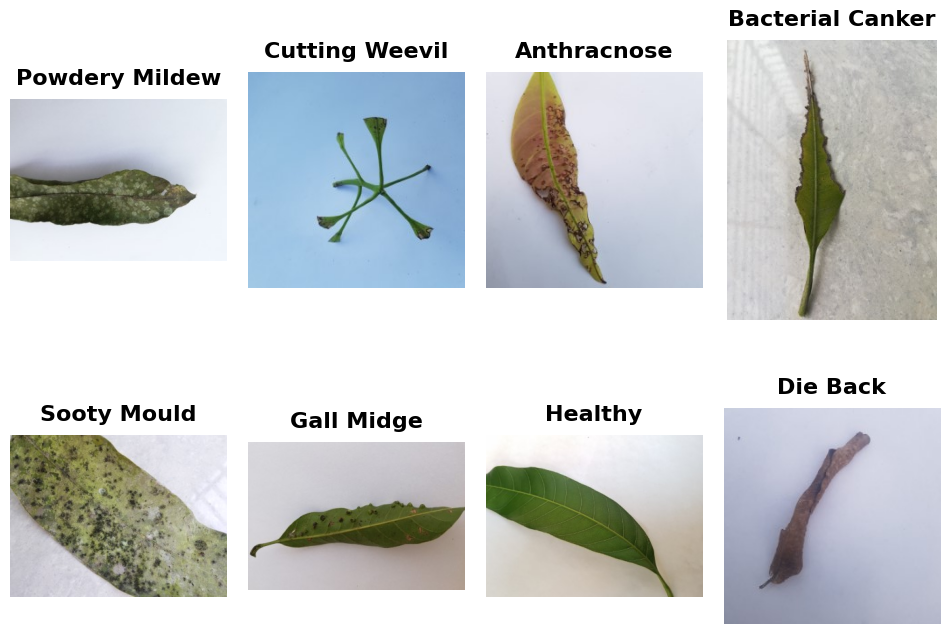

In [44]:
import matplotlib.pyplot as plt
import cv2
import random

# All unique class ber koro
classes = dataset['labels'].unique()

# Figure size
plt.figure(figsize=(12, 8))

for idx, cls in enumerate(classes):
    # Specific class path
    class_paths = dataset[dataset['labels'] == cls]['paths'].values

    # Randomle 1 image choice
    img_path = random.choice(class_paths)

    # Read image and Convert RGB
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Add subplot
    ax = plt.subplot(2, 4, idx + 1)  # 2 row 8 coloum
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(cls, fontsize=16, fontweight='bold', pad=10)  # Big tittle &bold

plt.subplots_adjust(wspace=0.1, hspace=0.2)  #Gap each image
plt.show()


## Splitting the data

In [11]:
training_data, temp_validation_data = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=42, stratify=dataset['labels'])
validation_data, test_data = train_test_split(temp_validation_data, test_size=0.05, shuffle=True, random_state=42, stratify=temp_validation_data['labels'])
print(f"Dimension of the training data: {training_data.shape[0]}")
print(f"Dimension of the validation data: {validation_data.shape[0]}")
print(f"Dimension of the test data: {test_data.shape[0]}")

Dimension of the training data: 3200
Dimension of the validation data: 760
Dimension of the test data: 40


## Preparing the data

In [12]:
# Batch size
batch_size = 32
# Dataset image shape
img_shape = (224, 224)

# The original dataset was augmentated
# This function only returns the image as is
def return_image(image):
    return image

# Create a ImageDataGenerator
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image)
validation_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image)

# Reading the images
training_data_gen = train_gen.flow_from_dataframe(training_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'
                                             )
validation_data_gen = train_gen.flow_from_dataframe(validation_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'
                                             )



Found 3200 validated image filenames belonging to 8 classes.
Found 760 validated image filenames belonging to 8 classes.


# Define the model

In [20]:
# The model
inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=2, data_format='channels_last')(inputs)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(4,4))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=1)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=512)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(units=512)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(units=8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model_name = "model.h5"
# Define callback function
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
# Stopping parameters
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)
# Learning rate changes during training
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 111, 111, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,325,640 (5.06 MB)

 Trainable params: 1,323,592 (5.05 MB)

 Non-trainable params: 2,048 (8.00 KB)

# Training the model

In [14]:
history = model.fit(training_data_gen,
                    validation_data=validation_data_gen,
                    epochs=50,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.4301 - loss: 1.7355
Epoch 1: val_loss improved from inf to 3.42631, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 428ms/step - accuracy: 0.4310 - loss: 1.7325 - val_accuracy: 0.3276 - val_loss: 3.4263 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6745 - loss: 0.9268
Epoch 2: val_loss improved from 3.42631 to 2.30827, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 383ms/step - accuracy: 0.6748 - loss: 0.9261 - val_accuracy: 0.3513 - val_loss: 2.3083 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7734 - loss: 0.6774
Epoch 3: val_loss improved from 2.30827 to 0.76346, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 378ms/step - accuracy: 0.7736 - loss: 0.6769 - val_accuracy: 0.7474 - val_loss: 0.7635 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8286 - loss: 0.4989
Epoch 4: val_loss did not improve from 0.76346
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.8286 - loss: 0.4990 - val_accuracy: 0.5171 - val_loss: 1.4316 - learning_rate: 1.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8378 - loss: 0.4336
Epoch 5: val_loss did not improve from 0.76346
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 373ms/step - accuracy: 0.8379 - loss: 0.4336 - val_accuracy: 0.6711 - val_loss: 1.2069 - learning_rate: 1.0000e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8775 - loss: 0.3515
Epoch 6: val_loss improved from 0.76346 to 0.66009, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 392ms/step - accuracy: 0.8775 - loss: 0.3515 - val_accuracy: 0.7711 - val_loss: 0.6601 - learning_rate: 1.0000e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8968 - loss: 0.2980
Epoch 7: val_loss improved from 0.66009 to 0.55234, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 418ms/step - accuracy: 0.8968 - loss: 0.2979 - val_accuracy: 0.8013 - val_loss: 0.5523 - learning_rate: 1.0000e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9042 - loss: 0.2664
Epoch 8: val_loss improved from 0.55234 to 0.52569, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 375ms/step - accuracy: 0.9042 - loss: 0.2664 - val_accuracy: 0.8342 - val_loss: 0.5257 - learning_rate: 1.0000e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9351 - loss: 0.2106
Epoch 9: val_loss improved from 0.52569 to 0.51543, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 409ms/step - accuracy: 0.9351 - loss: 0.2106 - val_accuracy: 0.8434 - val_loss: 0.5154 - learning_rate: 1.0000e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9455 - loss: 0.1847
Epoch 10: val_loss did not improve from 0.51543
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 373ms/step - accuracy: 0.9454 - loss: 0.1847 - val_accuracy: 0.7711 - val_loss: 0.7116 - learning_rate: 1.0000e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9395 - loss: 0.1873
Epoch 11: val_loss improved from 0.51543 to 0.51383, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 375ms/step - accuracy: 0.9395 - loss: 0.1873 - val_accuracy: 0.8474 - val_loss: 0.5138 - learning_rate: 1.0000e-04
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9422 - loss: 0.1821
Epoch 12: val_loss did not improve from 0.51383
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 387ms/step - accuracy: 0.9422 - loss: 0.1821 - val_accuracy: 0.7553 - val_loss: 0.8146 - learning_rate: 1.0000e-04
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9536 - loss: 0.1503
Epoch 13: val_loss did not improve from 0.51383
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 371ms/step - accuracy: 0.9536 - loss: 0.1503 - val_accuracy: 0.8776 - val_loss: 0.5212 - learning_rate: 1.0000e-04
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9611 - loss: 0.1342
Epoch 14: val_loss did not improve from 0.51383

Epoch 14: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.9611 - l

100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 396ms/step - accuracy: 0.9603 - loss: 0.1354 - val_accuracy: 0.9197 - val_loss: 0.2736 - learning_rate: 2.0000e-05
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9661 - loss: 0.1096
Epoch 16: val_loss improved from 0.27363 to 0.25272, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 383ms/step - accuracy: 0.9662 - loss: 0.1095 - val_accuracy: 0.9171 - val_loss: 0.2527 - learning_rate: 2.0000e-05
Epoch 17/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9676 - loss: 0.0986
Epoch 17: val_loss did not improve from 0.25272
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 380ms/step - accuracy: 0.9676 - loss: 0.0986 - val_accuracy: 0.9184 - val_loss: 0.2779 - learning_rate: 2.0000e-05
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9718 - loss: 0.0926
Epoch 18: val_loss did not improve from 0.25272
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 384ms/step - accuracy: 0.9718 - loss: 0.0927 - val_accuracy: 0.9105 - val_loss: 0.2936 - learning_rate: 2.0000e-05
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9724 - loss: 0.0923
Epoch 19: val_loss did not improve from 0.25272

Epoch 19: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 383ms/step - accuracy: 0.9724 - lo

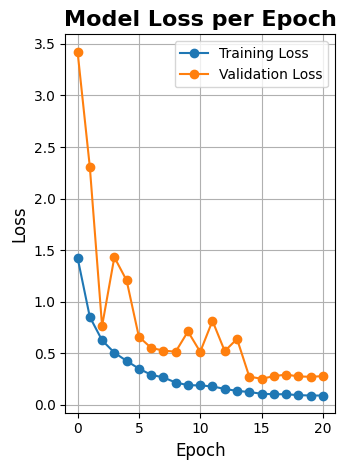

In [49]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss per Epoch', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Plot training results

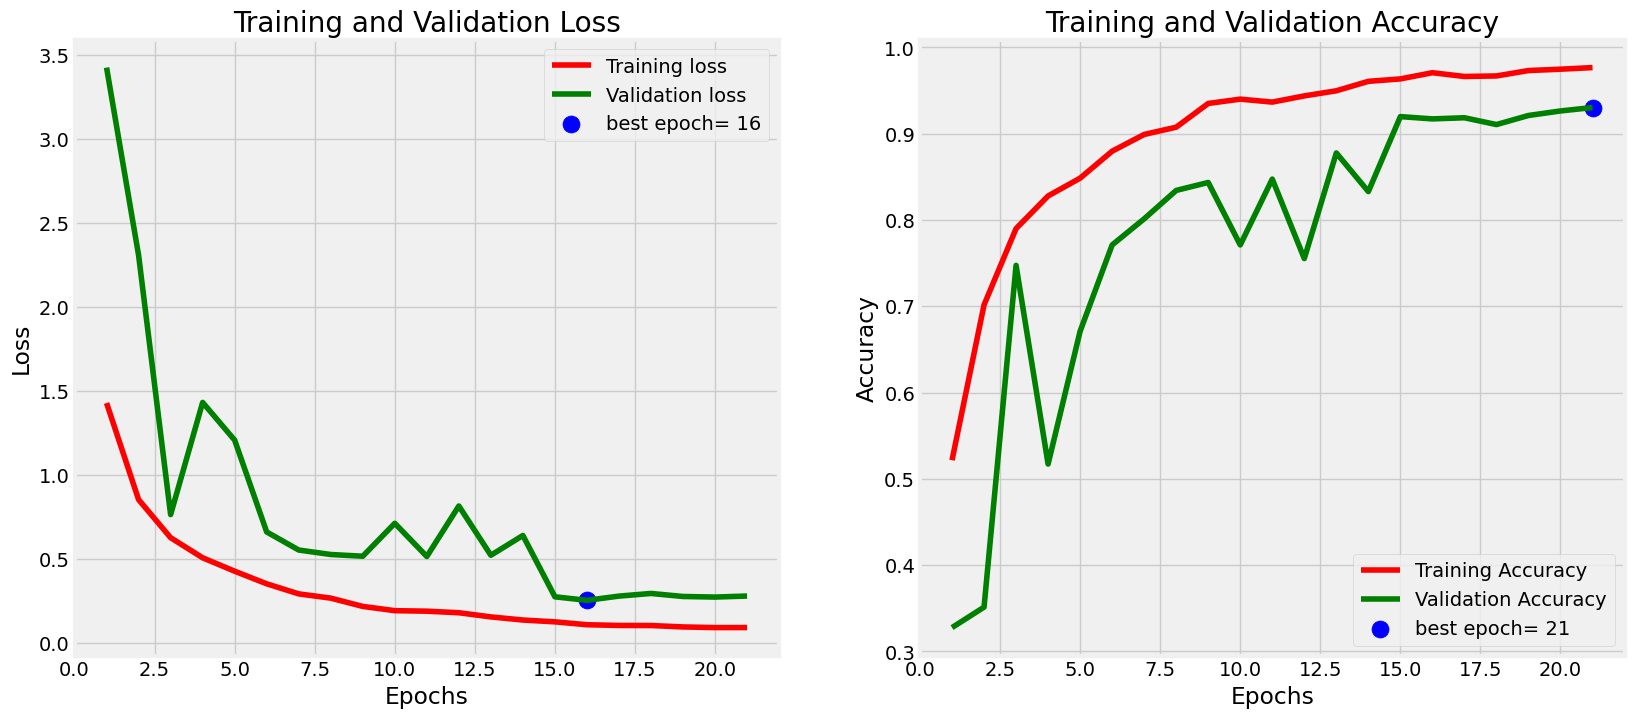

In [21]:
training_acc = history.history['accuracy']
training_loss = history.history['loss']
validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']

# Select the min loss and the max accuracy achieved in the validation
index_loss = np.argmin(validation_loss)
val_lowest = validation_loss[index_loss]
index_acc = np.argmax(validation_acc)
acc_highest = validation_acc[index_acc]

# Arrange for plotting
epochs = [i+1 for i in range(len(training_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'r', label= 'Training loss')
plt.plot(epochs, validation_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_acc, 'r', label= 'Training Accuracy')
plt.plot(epochs, validation_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Testing the model

Found 40 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


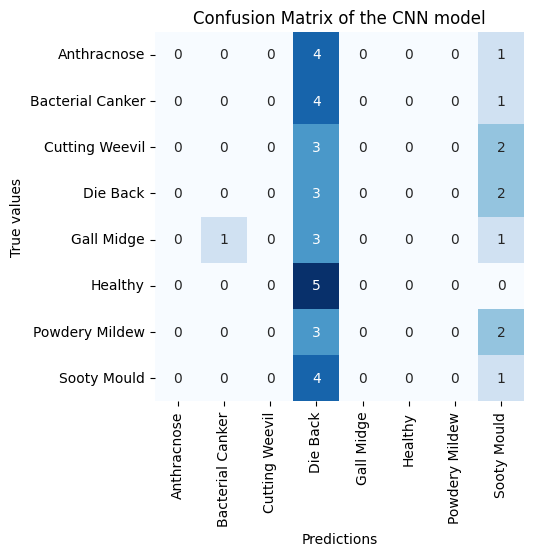

                  precision    recall  f1-score   support

     Anthracnose       0.00      0.00      0.00         5
Bacterial Canker       0.00      0.00      0.00         5
  Cutting Weevil       0.00      0.00      0.00         5
        Die Back       0.10      0.60      0.18         5
      Gall Midge       0.00      0.00      0.00         5
         Healthy       0.00      0.00      0.00         5
  Powdery Mildew       0.00      0.00      0.00         5
     Sooty Mould       0.10      0.20      0.13         5

        accuracy                           0.10        40
       macro avg       0.03      0.10      0.04        40
    weighted avg       0.03      0.10      0.04        40



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
plt.style.use('default')
# Define ImageDataGenerator and normalize
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image, rescale=1./255)

# Reading the images
test_data_gen = test_gen.flow_from_dataframe(test_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'
                                             )
# Predict
preds = model.predict(test_data_gen)
# Select the max argument for each predictions
y_pred = np.argmax(preds, axis=1)

# Get classes names and mapping
g_dict = test_data_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_data_gen.classes, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of the CNN model')
plt.show()

# Classification report
print(classification_report(test_data_gen.classes, y_pred, target_names= classes))

# Grad-CAM

In [23]:
def get_img_array(img_path, img_shape):
    # Load image
    img = tf.keras.utils.load_img(img_path, target_size=img_shape)
    # Convert to array
    array = tf.keras.utils.img_to_array(img) / 255.0
    # Add a dimension to the array image
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, normalizing the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    return superimposed_img

## Display a sample of the test images

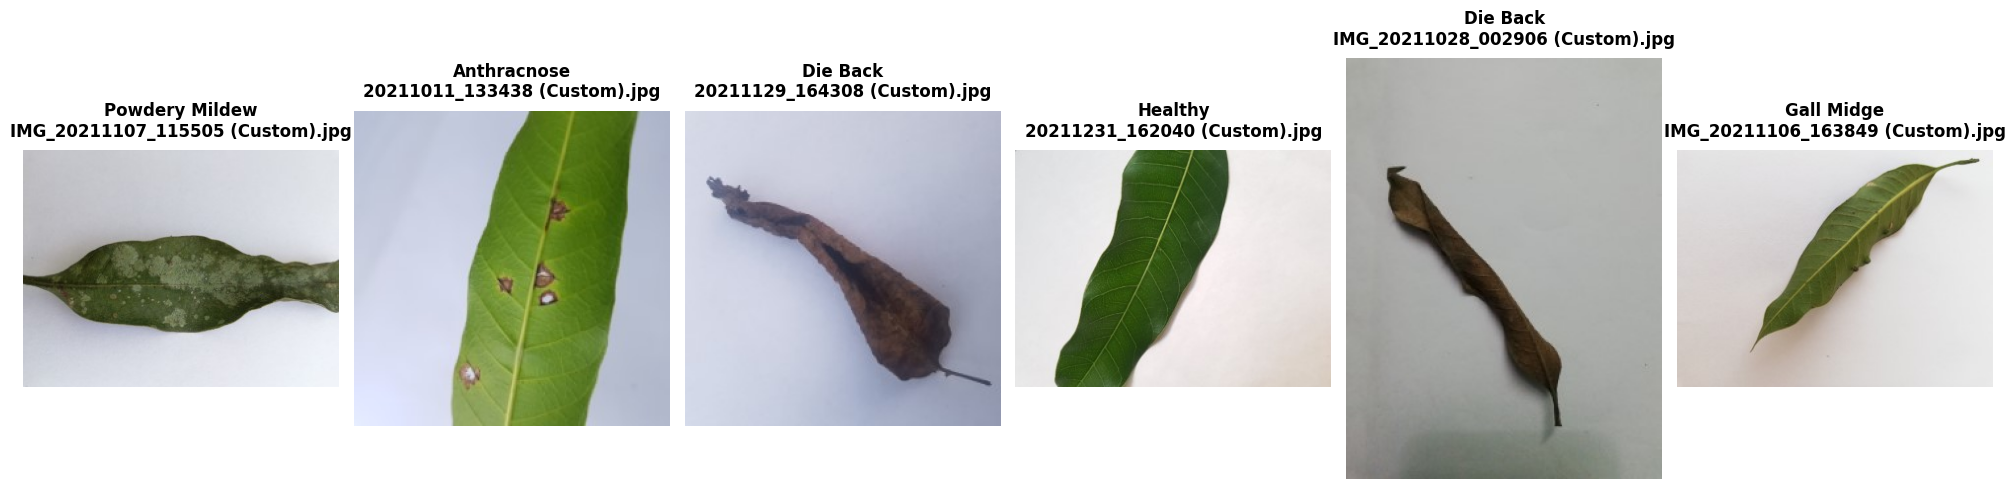

In [53]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axs = plt.subplots(1, 6, figsize=(20, 8))

for i, ax in enumerate(axs):
    img_path = test_data.iloc[i, 0]
    img_label = test_data.iloc[i, 1]
    img_name = img_path.split('/')[-1]   # File name (last part)

    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

    # show for image name or file name
    ax.set_title(f"{img_label}\n{img_name}", fontsize=12, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_51']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


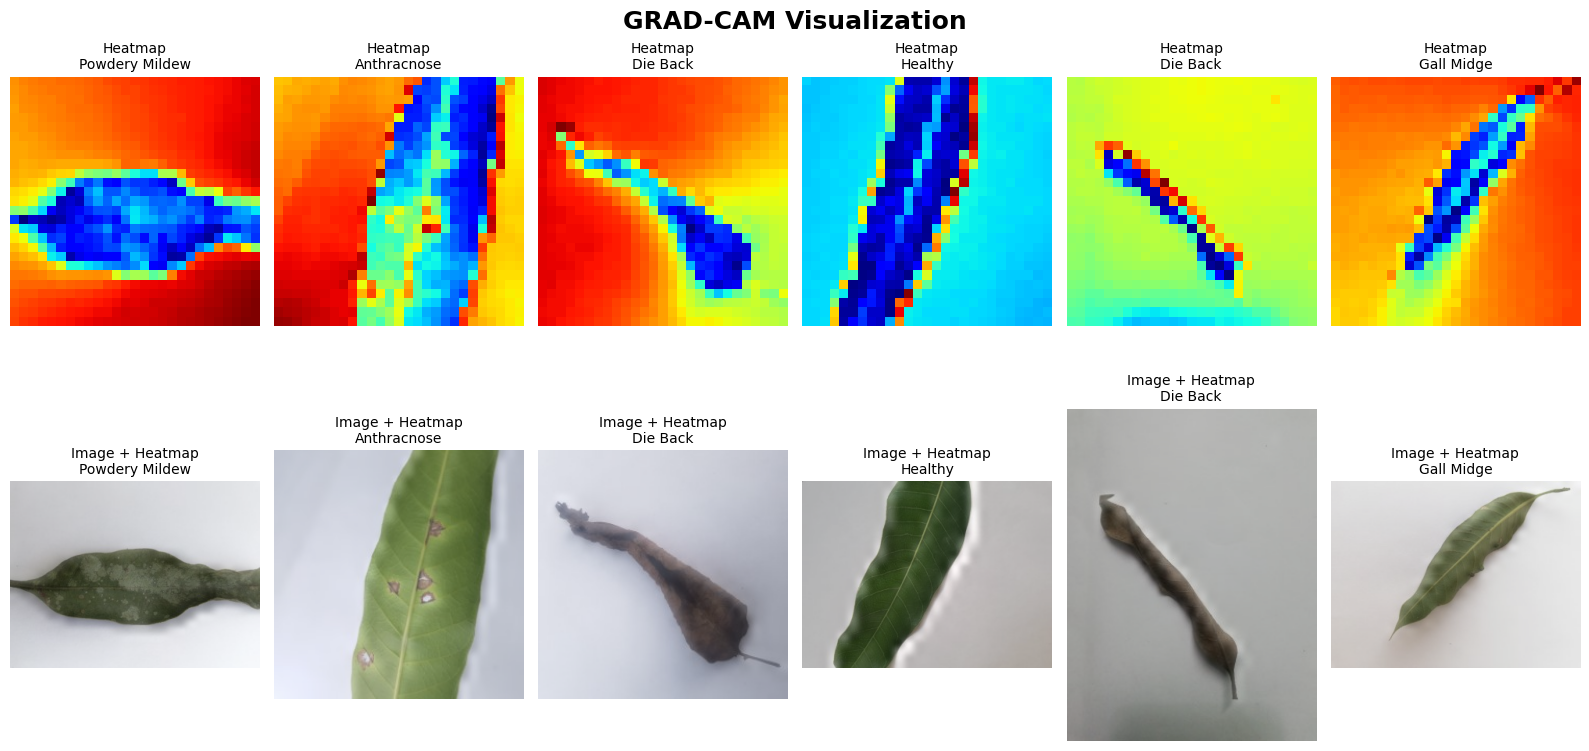

In [42]:
last_conv_layer_name = "max_pooling2d_6"  # layer name

fig, ax = plt.subplots(2, 6, figsize=(16, 8))

for i in range(6):
    img_array = get_img_array(test_data.iloc[i, 0], img_shape=img_shape)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    ax[0, i].imshow(heatmap, cmap='jet')
    ax[0, i].set_title(f"Heatmap\n{test_data.iloc[i,1]}", fontsize=10)
    ax[0, i].axis('off')

    ax[1, i].imshow(display_gradcam(test_data.iloc[i, 0], heatmap))
    ax[1, i].set_title(f"Image + Heatmap\n{test_data.iloc[i,1]}", fontsize=10)
    ax[1, i].axis('off')

plt.tight_layout()
fig.text(0.5, 0.95, "GRAD-CAM Visualization", ha='center', fontsize=18, fontweight='bold')
plt.show()
